# Federated Learning with HV Circuit Breaker Maintenance Data - Main

## Step 1: Install Required Packages

In [1]:
%pip install tensorflow tensorflow-federated pandas numpy matplotlib scikit-learn openpyxl

## Step 2: Import required packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Importing custom functions
import breaker_functions as bf

## Step 3: Data Loading and Inspection

In [3]:
# Load data
data = pd.read_excel("HV_Circuit_Breaker_Maintenance_Data.xlsx", sheet_name='Sheet1')

# Handle missing values - fill with median for numerical columns
# Fill missing values with median for numerical columns
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col].fillna(data[col].median(), inplace=True)

# Keep original for non-IID partitioning
original_df = data.copy()

<ipython-input-3-41a495f81c2d>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-3-41a495f81c2d>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## Step 4: Preprocess and split

In [4]:
# Preprocess breaker data
X, y, scaler = bf.preprocess_breaker_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Step 5: Federated Data Preparation (Fixed with proper train/test split)

In [5]:
# First, let's get the indices for train/test split
# We will use the same split for both IID and non-IID datasets
# Get the indices for the training set
train_idx, _ = train_test_split(
    original_df.index,
    test_size=0.2,
    random_state=42,
    stratify=original_df['Maintenance_required']
)

# Create IID and non-IID datasets
iid_client_data = bf.create_iid_federated_data(X_train, y_train)
non_iid_client_data = bf.create_non_iid_federated_data(original_df.loc[train_idx])

## Step 6: Custom Federated Data Partitioning

In [6]:
# Create client data for different partition types
client_data_iid = bf.create_client_data(X_train, y_train, partition_type='iid')
client_data_label_skew = bf.create_client_data(X_train, y_train, partition_type='label_skew')
client_data_feature_skew = bf.create_client_data(X_train, y_train, partition_type='feature_skew')

## Step 7: Train Model for FedAvg (IID and Non-IID) and Plot Results

Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1
IID - Loss: 0.8285, Acc: 0.5067
Non-IID - Loss: 0.7317, Acc: 0.5555
---
Round 2
IID - Loss: 0.6783, Acc: 0.5957
Non-IID - Loss: 0.6659, Acc: 0.6025
---
Round 3
IID - Loss: 0.6231, Acc: 0.6582
Non-IID - Loss: 0.6461, Acc: 0.6277
---
Round 4
IID - Loss: 0.5945, Acc: 0.6798
Non-IID - Loss: 0.6367, Acc: 0.6420
---
Round 5
IID - Loss: 0.5736, Acc: 0.6970
Non-IID - Loss: 0.6289, Acc: 0.6522
---
Round 6
IID - Loss: 0.5580, Acc: 0.7117
Non-IID - Loss: 0.6228, Acc: 0.6582
---
Round 7
IID - Loss: 0.5466, Acc: 0.7210
Non-IID - Loss: 0.6181, Acc: 0.6620
---
Round 8
IID - Loss: 0.5383, Acc: 0.7210
Non-IID - Loss: 0.6141, Acc: 0.6660
---
Round 9
IID - Loss: 0.5318, Acc: 0.7215
Non-IID - Loss: 0.6106, Acc: 0.6678
---
Round 10
IID - Loss: 0.5257, Acc: 0.7293
Non-IID - Loss: 0.6072, Acc: 0.6708
---
Round 11
IID - Loss: 0.5188, Acc: 0.7295
Non-IID - Loss: 0.6041, Acc: 0.6725
---
Round 12
IID - Loss: 0.5109, Acc: 0.7345
Non-IID - Loss: 0.6012, Acc: 0.6787
---
Round 13
IID - Loss: 0.5027, Acc: 0.7

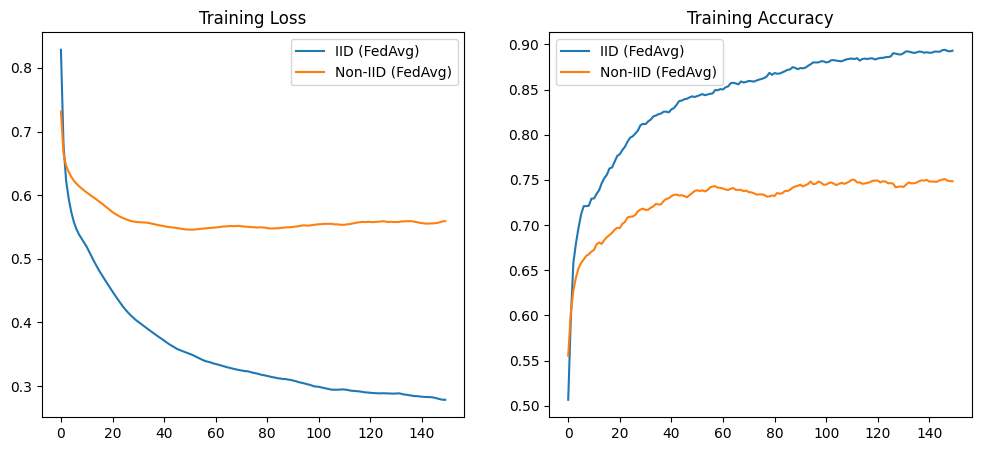

In [7]:
# Training parameters
NUM_ROUNDS = 150
CLIENT_EPOCHS = 5

# Build processes for training
# and evaluation
train_process = bf.build_iid_fedaverage_process(X_train)

# Initialize the global model
# and the metrics dictionary
# to store the loss and accuracy for each round
state = train_process.initialize()

metrics = {'iid': {'loss': [], 'acc': []}, 'non_iid': {'loss': [], 'acc': []}}

# Training Loop (Fixed Metrics Handling)
# Iterate over the number of rounds
# and train the model on both IID and non-IID datasets
for round_num in range(NUM_ROUNDS):
    # Train IID
    state, metrics_iid = train_process.next(state, iid_client_data)
    # Updated metrics access - use client_work instead of train
    client_metrics = metrics_iid['client_work']['train']
    metrics['iid']['loss'].append(client_metrics['loss'])
    metrics['iid']['acc'].append(client_metrics['binary_accuracy'])

    # Train Non-IID
    state, metrics_non_iid = train_process.next(state, non_iid_client_data)
    client_metrics = metrics_non_iid['client_work']['train']
    metrics['non_iid']['loss'].append(client_metrics['loss'])
    metrics['non_iid']['acc'].append(client_metrics['binary_accuracy'])

    print(f"Round {round_num+1}")
    print(f"IID - Loss: {metrics['iid']['loss'][-1]:.4f}, Acc: {metrics['iid']['acc'][-1]:.4f}")
    print(f"Non-IID - Loss: {metrics['non_iid']['loss'][-1]:.4f}, Acc: {metrics['non_iid']['acc'][-1]:.4f}")
    print("---")


# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['iid']['loss'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['loss'], label='Non-IID (FedAvg)')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['iid']['acc'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['acc'], label='Non-IID (FedAvg)')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Step 8: Training with IID (FedAvg) and Non-IID (FedProx)

Round 1
IID (FedAvg) - Loss: 0.7979, Acc: 0.5040
Non-IID (FedProx) - Loss: 0.7622, Acc: 0.5293
---
Round 2
IID (FedAvg) - Loss: 0.7168, Acc: 0.5580
Non-IID (FedProx) - Loss: 0.7066, Acc: 0.5575
---
Round 3
IID (FedAvg) - Loss: 0.6662, Acc: 0.6100
Non-IID (FedProx) - Loss: 0.6733, Acc: 0.5840
---
Round 4
IID (FedAvg) - Loss: 0.6327, Acc: 0.6475
Non-IID (FedProx) - Loss: 0.6527, Acc: 0.6053
---
Round 5
IID (FedAvg) - Loss: 0.6094, Acc: 0.6705
Non-IID (FedProx) - Loss: 0.6388, Acc: 0.6280
---
Round 6
IID (FedAvg) - Loss: 0.5921, Acc: 0.6880
Non-IID (FedProx) - Loss: 0.6279, Acc: 0.6417
---
Round 7
IID (FedAvg) - Loss: 0.5786, Acc: 0.6995
Non-IID (FedProx) - Loss: 0.6190, Acc: 0.6488
---
Round 8
IID (FedAvg) - Loss: 0.5667, Acc: 0.7105
Non-IID (FedProx) - Loss: 0.6118, Acc: 0.6535
---
Round 9
IID (FedAvg) - Loss: 0.5566, Acc: 0.7140
Non-IID (FedProx) - Loss: 0.6063, Acc: 0.6565
---
Round 10
IID (FedAvg) - Loss: 0.5470, Acc: 0.7210
Non-IID (FedProx) - Loss: 0.6020, Acc: 0.6610
---
Round 11


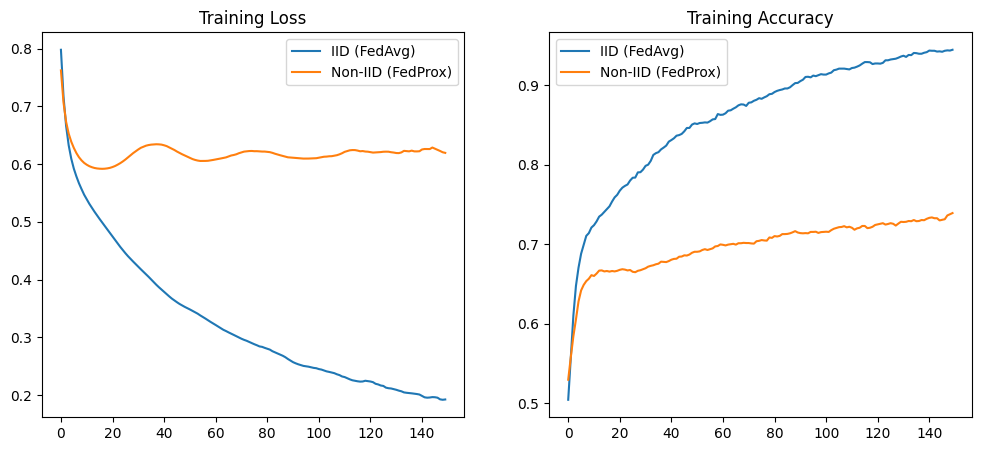

In [8]:
# Training parameters
NUM_ROUNDS = 150
CLIENT_EPOCHS = 5
MU = 0.05  # FedProx proximal term weight (typical range: 0.01-1)

# IID Process (FedAvg)
iid_process = bf.build_iid_fedaverage_process(X_train)

# Non-IID Process (FedProx)
non_iid_process = bf.build_non_iid_fedaverage_process(X_train, MU)

# Initialize states
iid_state = iid_process.initialize()
non_iid_state = non_iid_process.initialize()


# Store metrics for both IID and Non-IID
metrics = {'iid': {'loss': [], 'acc': []}, 'non_iid': {'loss': [], 'acc': []}}

# Training loop
for round_num in range(NUM_ROUNDS):
    # Train IID (FedAvg)
    iid_state, metrics_iid = iid_process.next(iid_state, iid_client_data)
    metrics['iid']['loss'].append(metrics_iid['client_work']['train']['loss'])
    metrics['iid']['acc'].append(metrics_iid['client_work']['train']['binary_accuracy'])

    # Train Non-IID (FedProx)
    non_iid_state, metrics_non_iid = non_iid_process.next(non_iid_state, non_iid_client_data)
    metrics['non_iid']['loss'].append(metrics_non_iid['client_work']['train']['loss'])
    metrics['non_iid']['acc'].append(metrics_non_iid['client_work']['train']['binary_accuracy'])

    print(f"Round {round_num+1}")
    print(f"IID (FedAvg) - Loss: {metrics['iid']['loss'][-1]:.4f}, Acc: {metrics['iid']['acc'][-1]:.4f}")
    print(f"Non-IID (FedProx) - Loss: {metrics['non_iid']['loss'][-1]:.4f}, Acc: {metrics['non_iid']['acc'][-1]:.4f}")
    print("---")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['iid']['loss'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['loss'], label='Non-IID (FedProx)')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['iid']['acc'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['acc'], label='Non-IID (FedProx)')
plt.title('Training Accuracy')
plt.legend()
plt.show()

## Step 9: FedAvg, FedProx and FedBN Comparison with IID Partitioning

In [9]:
# Train and evaluate different methods on IID data
history_fedavg_iid = bf.train_fedavg(client_data=client_data_iid, num_rounds=20, X_train=X_train)
history_fedprox_iid = bf.train_fedprox(client_data=client_data_iid, num_rounds=20, mu=0.1, X_train=X_train)
history_fedbn_iid = bf.train_fedbn(client_data=client_data_iid, num_rounds=20, X_train=X_train)

Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.62375), ('loss', 0.6589922), ('num_examples', 4000), ('num_batches', 250)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.676), ('loss', 0.58087516), ('num_examples', 4000), ('num_batches', 250)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.7075), ('loss', 0.5422869), ('num_examples', 4000), ('num_batches', 250)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)

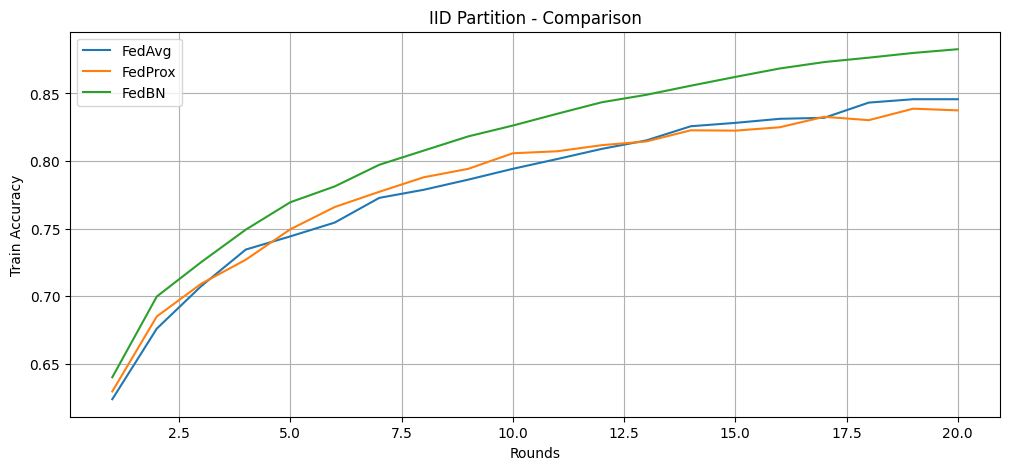

In [10]:
# Plot training curves for IID partition
bf.plot_training_curves_client_work(
    [history_fedavg_iid, history_fedprox_iid, history_fedbn_iid],
    labels=["FedAvg", "FedProx", "FedBN"],
    title="IID Partition - Comparison"
)

In [11]:
# Display Summary of final accuracy for each method
summary_table = bf.summarize_iid_accuracy(
    [history_fedavg_iid, history_fedprox_iid, history_fedbn_iid],
    ["FedAvg", "FedProx", "FedBN"]
)

print("Federated Training Summary")
display(summary_table)

Federated Training Summary


,Algorithm,Final Train Accuracy
0,FedAvg,0.84575
1,FedProx,0.83750
2,FedBN,0.88275


## Step 10: Non-IID Evaluation: Label Skew and Feature Skew


/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9595), ('loss', 0.13119443), ('num_examples', 4000), ('num_batches', 251)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.956), ('loss', 0.10877587), ('num_examples', 4000), ('num_batches', 251)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9475), ('loss', 0.11201054), ('num_examples', 4000), ('num_batches', 251)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0

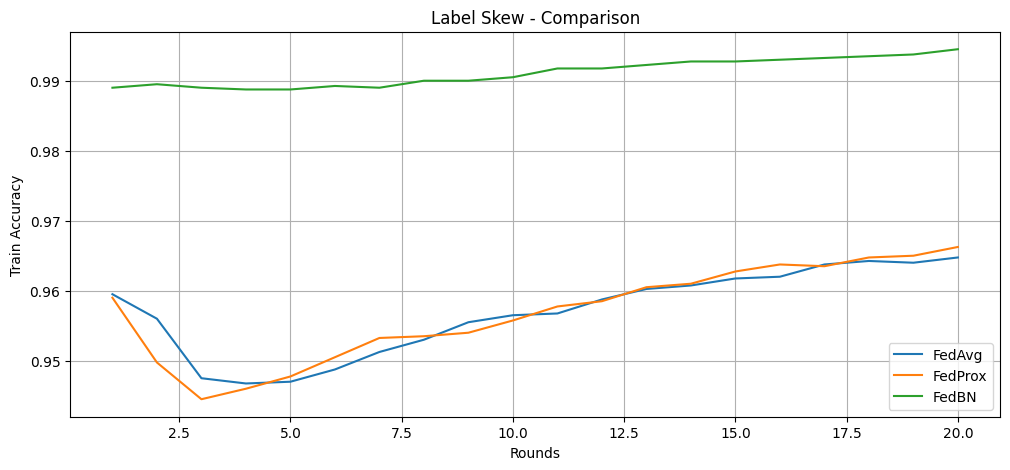

In [12]:
# Train and evaluate different methods on Skewed data
history_fedavg_label = bf.train_fedavg(client_data=client_data_label_skew, num_rounds=20, X_train=X_train)
history_fedprox_label = bf.train_fedprox(client_data=client_data_label_skew, num_rounds=20, mu=0.1, X_train=X_train)
history_fedbn_label = bf.train_fedbn(client_data=client_data_label_skew, num_rounds=20, X_train=X_train)

# Plot comparison for Label Skew
bf.plot_training_curves_client_work(
    [history_fedavg_label, history_fedprox_label, history_fedbn_label],
    labels=["FedAvg", "FedProx", "FedBN"],
    title="Label Skew - Comparison"
)

Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.66475), ('loss', 0.6031466), ('num_examples', 4000), ('num_batches', 253)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.72525), ('loss', 0.53007495), ('num_examples', 4000), ('num_batches', 253)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.75825), ('loss', 0.49684763), ('num_examples', 4000), ('num_batches', 253)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite'

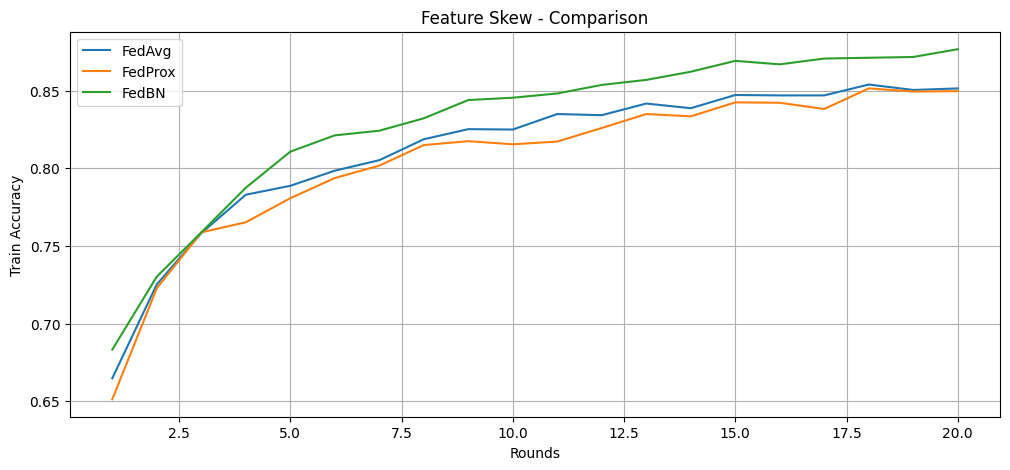

In [13]:
# Train and evaluate different methods on Feature Skewed data
history_fedavg_feature =bf.train_fedavg(client_data=client_data_feature_skew, num_rounds=20, X_train=X_train)
history_fedprox_feature = bf.train_fedprox(client_data=client_data_feature_skew, num_rounds=20, mu=0.1, X_train=X_train)
history_fedbn_feature = bf.train_fedbn(client_data=client_data_feature_skew,num_rounds=20, X_train=X_train)

# Plot comparison for Feature Skew
bf.plot_training_curves_client_work(
    [history_fedavg_feature, history_fedprox_feature, history_fedbn_feature],
    labels=["FedAvg", "FedProx", "FedBN"],
    title="Feature Skew - Comparison"
)

In [14]:
# Display Summary of final accuracy for each method
# for non-IID partition
summary_all = bf.summarize_non_iid_accuracy(
  [history_fedavg_iid, history_fedprox_iid, history_fedbn_iid,
    history_fedavg_label, history_fedprox_label, history_fedbn_label,
    history_fedavg_feature, history_fedprox_feature, history_fedbn_feature],
  ["FedAvg (IID)", "FedProx (IID)", "FedBN (IID)",
    "FedAvg (Label Skew)", "FedProx (Label Skew)", "FedBN (Label Skew)",
    "FedAvg (Feature Skew)", "FedProx (Feature Skew)", "FedBN (Feature Skew)"]
)
print("Federated Training Summary")
display(summary_table)

Federated Training Summary


,Algorithm,Final Train Accuracy
0,FedAvg,0.84575
1,FedProx,0.83750
2,FedBN,0.88275
